In [1]:
list.of.packages <- c("ggpubr","RColorBrewer","extrafont","hrbrthemes","tidyverse","stargazer","dplyr","ggplot2")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages, repos = "http://cran.us.r-project.org")

invisible(lapply(list.of.packages, library, character.only = TRUE))

select <- dplyr::select

options(repr.matrix.max.rows=50, repr.matrix.max.cols=500) 

Loading required package: ggplot2

Loading required package: magrittr

Registering fonts with R

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.1.0     ✔ dplyr   0.8.4
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
✔ purrr   0.3.3     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract()   masks magrittr::extract()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ purrr::set_names() masks magrittr::set_names()


Please cite as: 


 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 




### Database with one row for each paper-country-model association

In [2]:
df <- read_csv("../5_Final_databases/output/database_multi_rows_each_paper.csv")
sprintf("%i x %i dataframe", nrow(df), ncol(df))

Parsed with column specification:
cols(
  .default = col_double(),
  ISO_3 = col_character(),
  Country = col_character(),
  Region = col_character(),
  title = col_character(),
  authors = col_character(),
  source = col_character(),
  doi = col_character(),
  abstract = col_character(),
  author_keywords = col_character(),
  model = col_character(),
  scopus_number = col_character(),
  WOS_number = col_character()
)

See spec(...) for full column specifications.



[1] "4996 x 53 dataframe"

In [3]:
nrow(subset(df,!is.na(model)))

[1] 875

In [4]:
path <- "../2_Treatment_database/output/database_one_row_each_paper.csv"
df_one <- read_csv(path)
sprintf("%i x %i dataframe", nrow(df_one), ncol(df_one))
sprintf("%i papers with at least one model identified", nrow(subset(df_one,!is.na(model))))

Parsed with column specification:
cols(
  ISO_3 = col_character(),
  Country = col_character(),
  Region = col_character(),
  title = col_character(),
  authors = col_character(),
  source = col_character(),
  doi = col_character(),
  abstract = col_character(),
  author_keywords = col_character(),
  publication_year = col_double(),
  horizon_year = col_double(),
  model = col_character(),
  scopus_number = col_character(),
  WOS_number = col_character()
)



[1] "4691 x 14 dataframe"

[1] "734 papers with at least one model identified"

### Get the list of topics ordered by descending topic representation

In [5]:
topics_table <- read_csv("../4_Manual_treatment_topic_table/ouput/Table_topics.csv")
sprintf("%i x %i dataframe", nrow(topics_table), ncol(topics_table))

Parsed with column specification:
cols(
  Index = col_double(),
  Name = col_character(),
  Terms = col_character(),
  Category = col_character(),
  Sector = col_character(),
  `Relevant IPCC WG3 chapter` = col_character(),
  T0.02 = col_double(),
  T0.02Title = col_double()
)



[1] "39 x 8 dataframe"

In [6]:
topics_table_ordered <- topics_table %>% 
                                arrange(desc(T0.02))

In [7]:
topics_list <- as.character(topics_table_ordered$Name)

### Long format

In [8]:
df <- df%>%
        select(Country, Region, model, 15:53) %>% 
        filter(!is.na(model))

In [9]:
df_ga <- gather(df, topic, measurement, 'Energy efficiency':'System', factor_key=TRUE)
df_ga <- df_ga %>% 
         filter(measurement>0 & !is.na(model))%>% 
         select(.,-c(measurement))
sprintf("%i x %i final dataframe", nrow(df_ga), ncol(df_ga))
head(df_ga,2)

[1] "5051 x 4 final dataframe"

Country,Region,model,topic
<chr>,<chr>,<chr>,<fct>
United Arab Emirates,Asia,MESSAGE,Energy efficiency
Bangladesh,Asia,MARKAL,Energy efficiency


#### Function to keep the number of model-study association per topic for the three most represented models and aggregate the number of model-study of the other models  for each topic 

In [10]:
top3models_others_topic <- function(topic_name) {
    df_topic <- df_ga %>% 
                filter(topic == topic_name)%>%
                dplyr::group_by(model)%>%
                dplyr::summarise(count = n())%>%
                mutate(topic=topic_name)
    #dataframe with the three models most often associated to the topic
    head_topic <- head(df_topic[order(-df_topic$count),],3) 
    head_topic <- data.frame(head_topic)
    #aggregation of all other models
    row_other <- c("Others",sum(tail(df_topic[order(-df_topic$count),],-3)$count),topic_name)
    head_topic[4,] <- row_other
    #rank column for apparition order in the graph (always row Other at the end)
    head_topic[,4] <- c(1,2,3,4)
    names(head_topic)[4] <- "Rank"
    head_topic$count <- as.double(head_topic$count)
    return(head_topic)
    }

In [11]:
df_tot <-  top3models_others_topic(topics_list[1])
df_tot

,model,count,topic,Rank
,<chr>,<dbl>,<chr>,<dbl>
1,CGE,145,Policy-Dvlpt-Eco,1
2,LEAP,119,Policy-Dvlpt-Eco,2
3,TIMES,116,Policy-Dvlpt-Eco,3
4,Others,495,Policy-Dvlpt-Eco,4


In [12]:
for (topic in topics_list[-1]){
    df_tot <- rbind(df_tot,top3models_others_topic(topic))
}

In [13]:
models_ordered <- df %>% 
                        group_by(model)%>%
                        summarise(n_mod = n())%>%
                        arrange(desc(n_mod))

In [14]:
models_list <- as.character(models_ordered$model)
models_list

[1] "CGE"                         "LEAP"                       
 [3] "TIMES"                       "MARKAL"                     
 [5] "Input-Output"                "AIM"                        
 [7] "IAM"                         "GAINS"                      
 [9] "PRIMES"                      "MESSAGE"                    
[11] "GCAM"                        "EPPA"                       
[13] "IMACLIM"                     "RICE"                       
[15] "MARKAL-MACRO"                "AQUACROP"                   
[17] "GEM-E3"                      "IMPACT"                     
[19] "WITCH"                       "IMAGE"                      
[21] "E3ME"                        "GTAP"                       
[23] "InVEST"                      "IPAC"                       
[25] "OseMOSYS"                    "GLOBIOM"                    
[27] "IGSM"                        "Social Accounting Matrices" 
[29] "ASF"                         "ASTRA"                      
[31] "E3MG"                        "PAGE"                       
[33] "POLES"                       "REMIND"                     
[35] "TIMES-MACRO"                 "Australian Stocks and Flows"
[37] "BLUES"                       "BUENAS"                     
[39] "C3IAM"                       "CLUE"                       
[41] "EDGE"                        "FASOM-GHG"                  
[43] "Gdyn"                        "GIAM"                       
[45] "ICES"                        "LEITAP"                     
[47] "MERGE"                       "PANTA RHEI"                 
[49] "Powerplan"                   "Threshold 21"               
[51] "TIMER"                       "WIOD"                       
[53] "World Energy Model"

In [15]:
df_tot <- df_tot%>%
                mutate(topic = factor(topic, levels = c(topics_list)),
                       model = factor(model, levels = c(models_list,"Others")))

### Histogram of the number of model-study association per topic

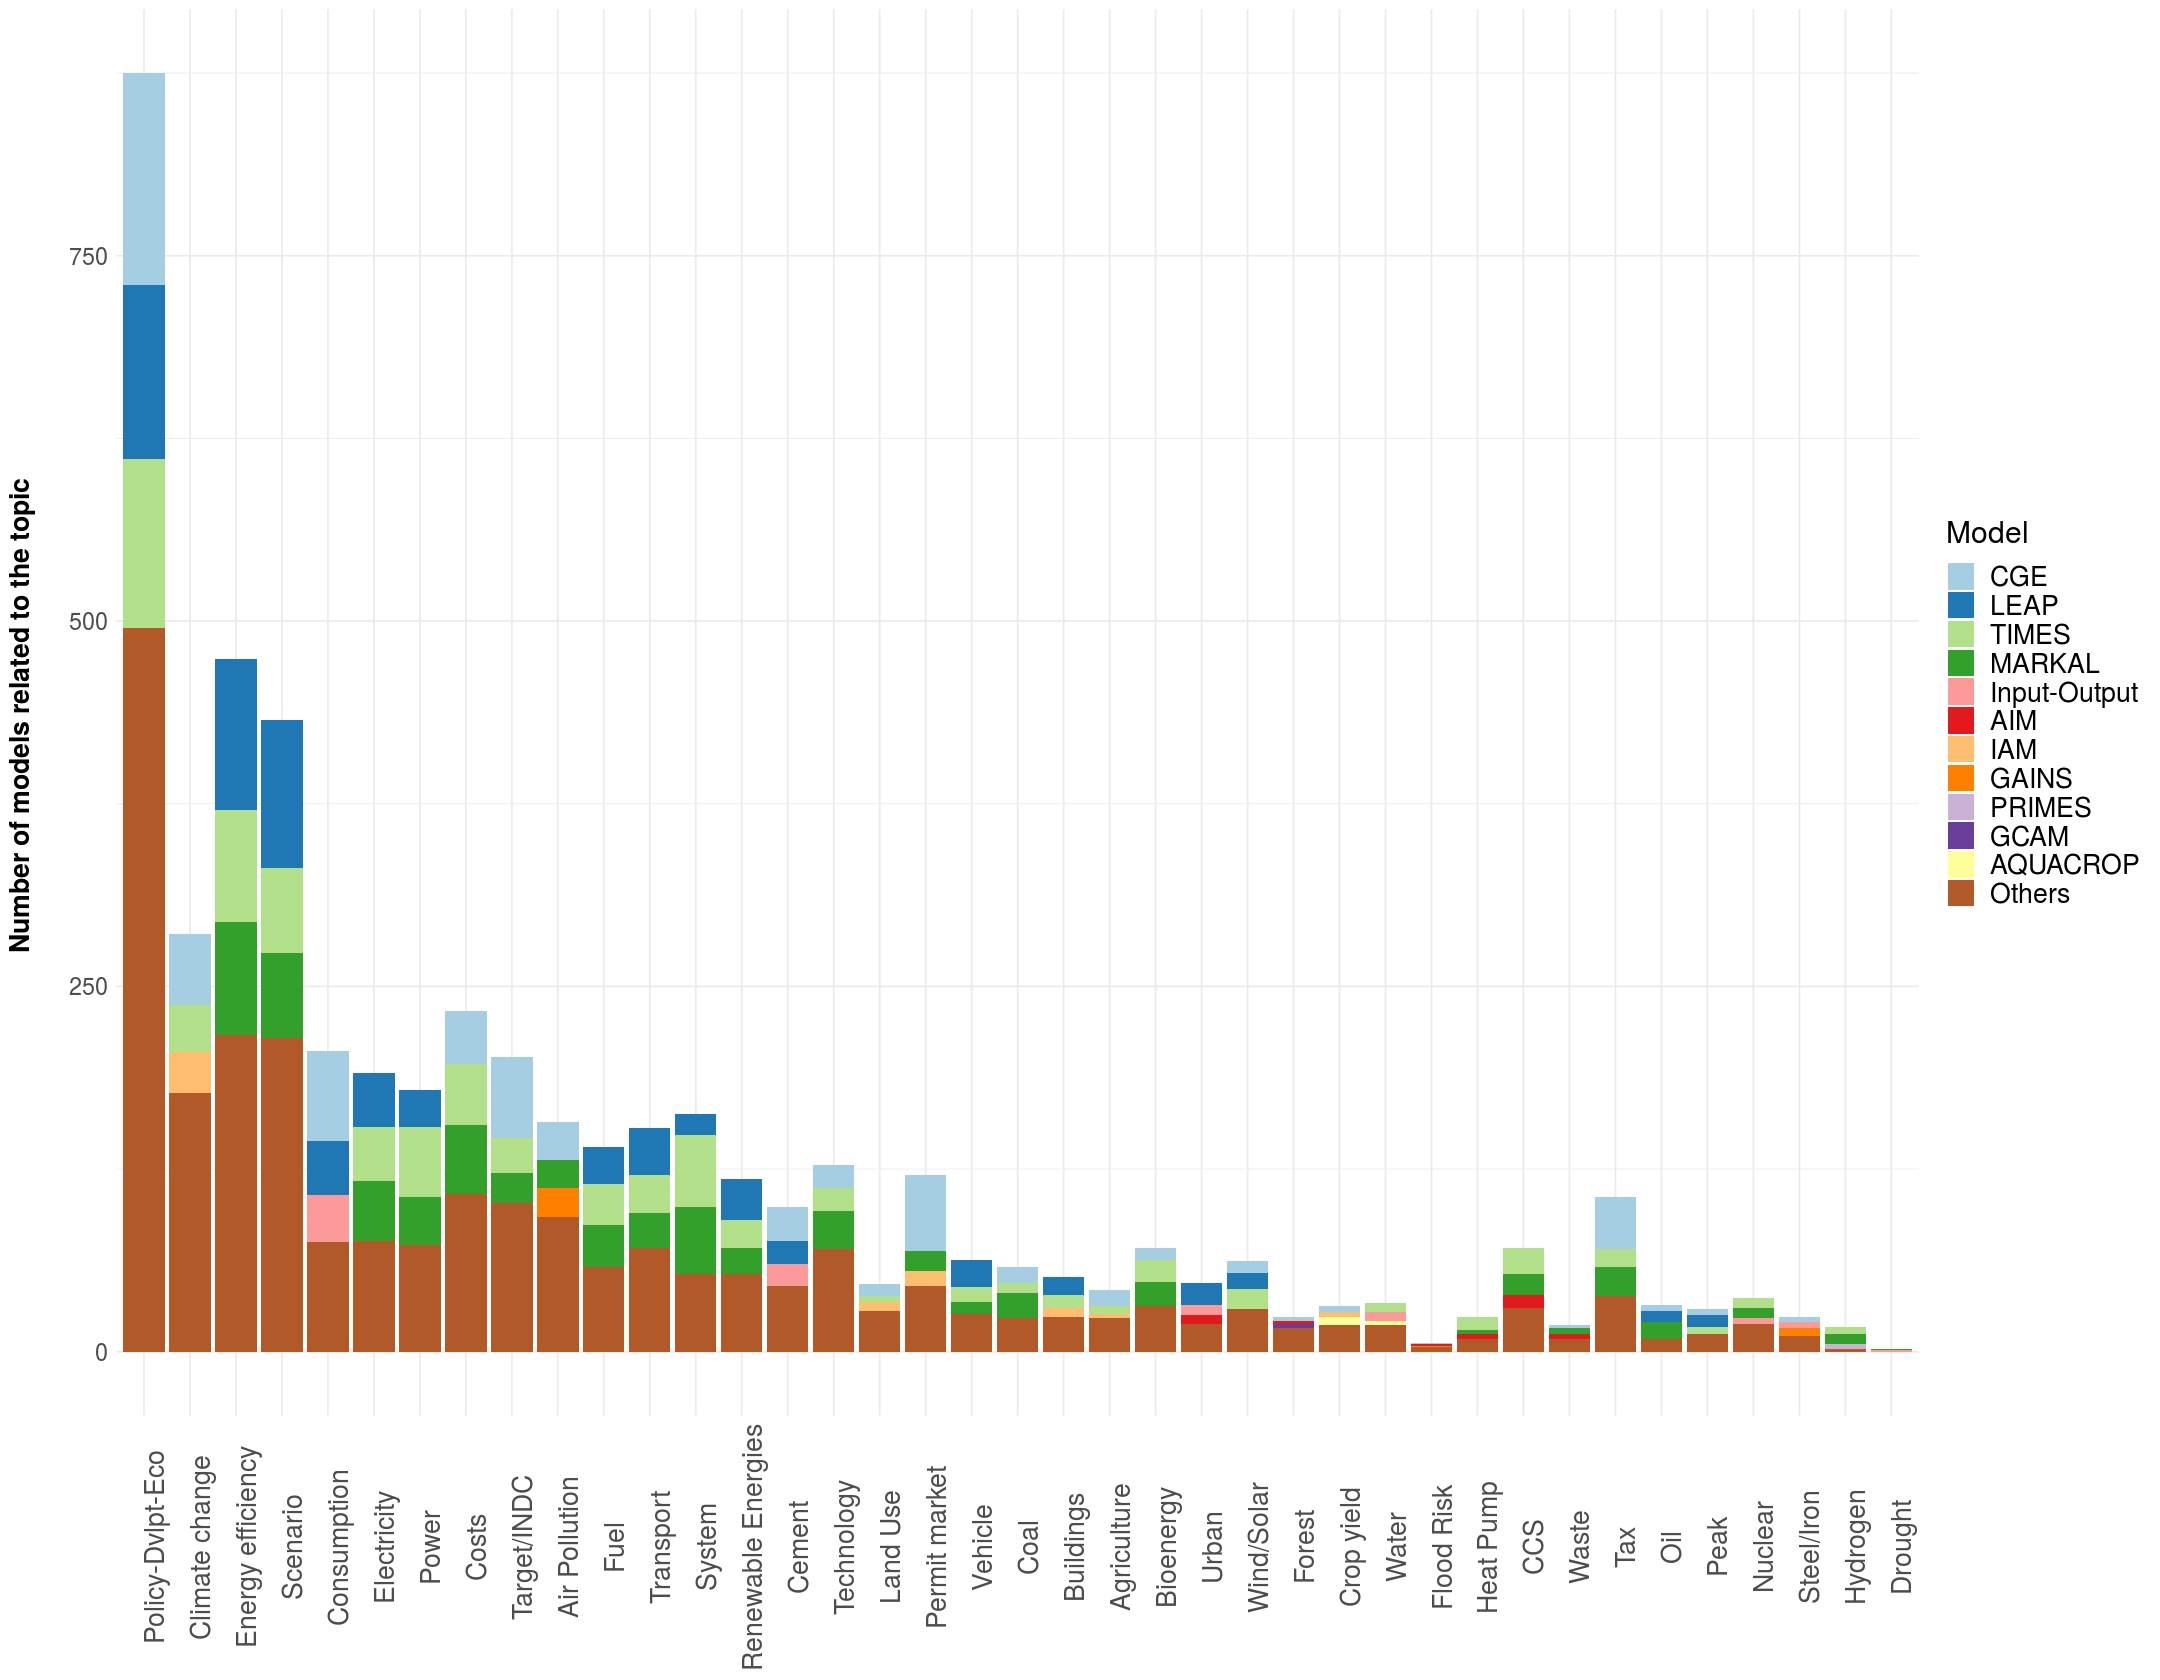

In [16]:
options(repr.plot.width=18, repr.plot.height=14)

plot1 <- ggplot(subset(df_tot, !is.na(topic))) + 
          geom_bar(aes(x=topic, y = count, fill=model),stat="identity")+
          ylab("Number of models related to the topic \n")+
          scale_fill_brewer(palette = "Paired")+
          labs(fill="Model")+
          theme_minimal()+
          theme(
            legend.title = element_text(size = 18),
            legend.text = element_text(size = 16),
            legend.position="right",
            axis.text.x = element_text(size = 16, angle =90),
            axis.text.y = element_text(size = 14),
            axis.title.x =  element_blank(),
            axis.title.y = element_text(size = 16, hjust = 0.5,face ="bold")
          )
plot1

In [17]:
ggsave('./output/Fig_SI10_topics_models.png', height=14, width=18, plot=plot1)

### Histogram of the number of model-study associations

In [18]:
models_ordered_reg <- df %>% 
                        group_by(model,Region)%>%
                        summarise(n_mod = n())%>%
                        arrange(desc(n_mod))%>%
                        ungroup()%>%
                        mutate(model = factor(model, levels = c(models_list)),
                               Region=factor(Region, levels = c('Antarctica','Oceania','Africa','Latin America',
                                        'North America','European Union','Europe','Asia')))

head(models_ordered_reg,2)

model,Region,n_mod
<fct>,<fct>,<int>
CGE,Asia,101
LEAP,Asia,85


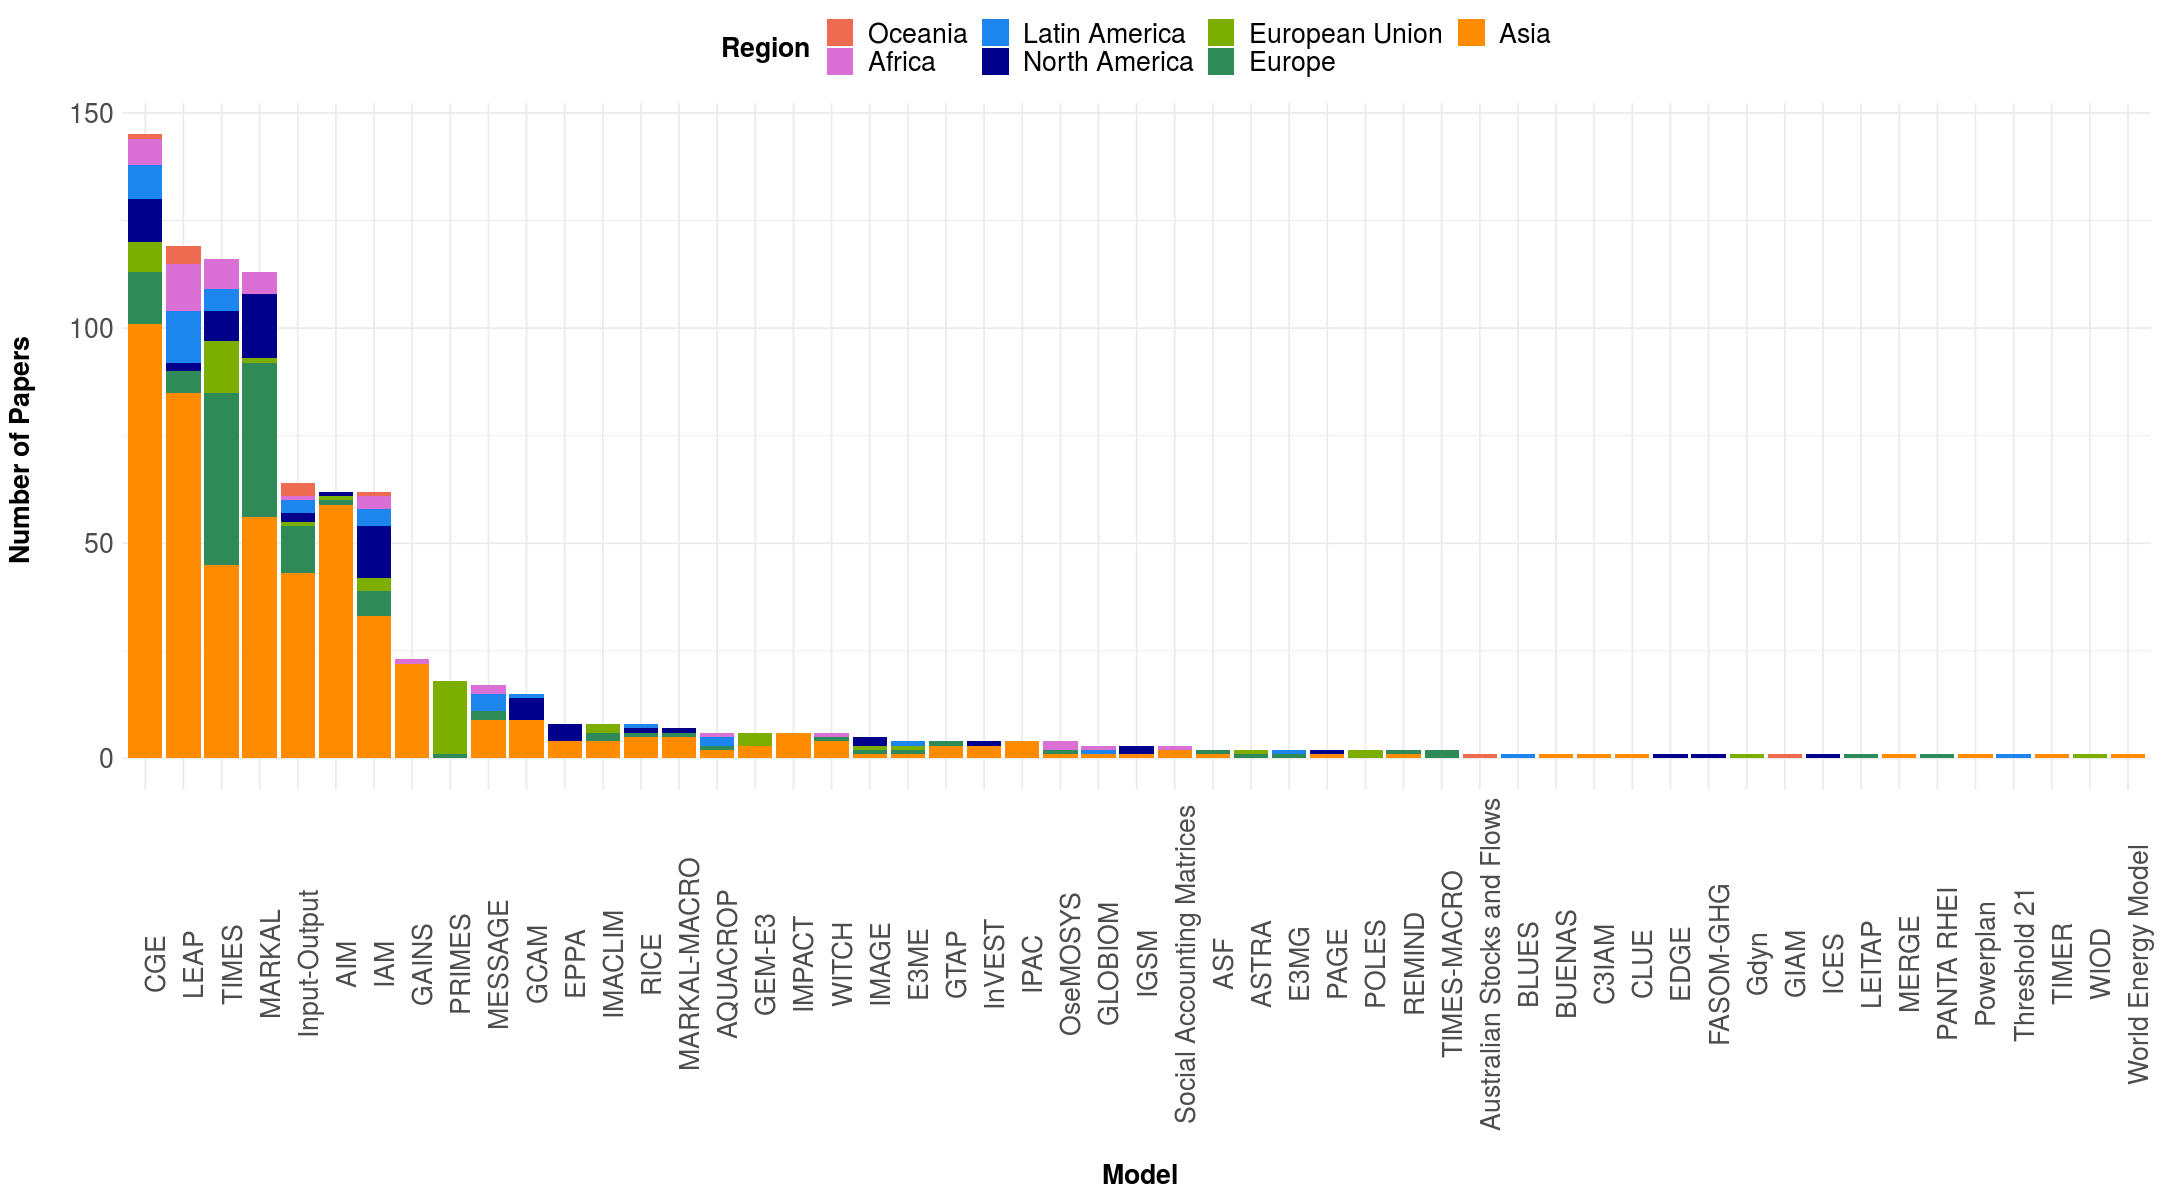

In [19]:
options(repr.plot.width=18, repr.plot.height=10)

plot2 <- ggplot(models_ordered_reg) + 
                  geom_bar(aes(x=model, y = n_mod, fill=Region),stat="identity")+
                  scale_fill_manual(values=c('Asia'='darkorange',
                                           'European Union'='#7CAE00',
                                           'Europe'='seagreen4',
                                           'North America'='darkblue',
                                           'Latin America'='dodgerblue2',
                                           'Africa'='orchid',
                                           'Oceania'='coral2', 
                                           'Antarctica'='#CAB2D6')) + 
                labs(x = " \n Model", y = "Number of Papers \n ", fill = "Region") + 
                theme_minimal()+
                theme(
                    plot.title = element_text(size = rel(2)),
                    legend.title = element_text(size = 16,face ="bold"),
                    legend.text = element_text(size = 16),
                    legend.position = 'top',
                    axis.text.x = element_text(size = 16,angle=90),
                    axis.text.y = element_text(size = 16),
                    axis.title.x = element_text(size = 16, hjust = 0.5,face ="bold"),
                    axis.title.y = element_text(size = 16, hjust = 0.5,face ="bold")
                  ) 
plot2

In [20]:
ggsave('./output/Fig_SI9_models_regions.png', height=10, width=18, plot=plot2)